In [9]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import seaborn as sns
from data_preprocessing import load_combined_data

In [10]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # disables optimizations for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [11]:
# Function to load preprocessed data
combined_data, combined_labels = load_combined_data(data_path='ES_InterDown_combined_data.csv', labels_path='ES_InterDown_combined_labels.csv',downsample = True)

In [12]:

# Map labels from original multi-class to binary
def map_labels(original_labels,classification_type='binary'):
    if classification_type == 'binary':
        label_map = {2: 0, 3: 1}  # 0: tightening, 1: untightening
        num_classes = 2
    return np.array([label_map[label] if label in label_map else -1 for label in original_labels]),num_classes

# Filter and preprocess the data
binary_labels,num_of_classes = map_labels(combined_labels,classification_type='binary')
valid_indices = binary_labels != -1
X = combined_data[valid_indices, :, 1:]  # exclude timestamps
y = binary_labels[valid_indices]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # can be removed as our code uses binary labels directly

# Convert to tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y_encoded)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, stratify=y_encoded)

# Print label distribution
unique_train, counts_train = torch.unique(y_train, return_counts=True)
unique_test, counts_test = torch.unique(y_test, return_counts=True)

print("Training label distribution:")
for label, count in zip(unique_train.tolist(), counts_train.tolist()):
    print(f"  Label {label_encoder.inverse_transform([label])[0]}: {count} samples")

print("Testing label distribution:")
for label, count in zip(unique_test.tolist(), counts_test.tolist()):
    print(f"  Label {label_encoder.inverse_transform([label])[0]}: {count} samples")

# Normalize input features
scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = StandardScaler()
    X_train[:, :, i] = torch.FloatTensor(scalers[i].fit_transform(X_train[:, :, i]))
    X_test[:, :, i] = torch.FloatTensor(scalers[i].transform(X_test[:, :, i]))

# DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

Training label distribution:
  Label 0: 657 samples
  Label 1: 267 samples
Testing label distribution:
  Label 0: 164 samples
  Label 1: 67 samples


Epoch [1/50]
  Train Loss: 0.0722, Test Loss: 0.0697
  Train Acc: 0.5660, Test Acc: 0.7056
  Class Performance: {np.int64(0): '0.6545', np.int64(1): '0.3483'}
  Current Weights: {np.int64(0): '0.2830', np.int64(1): '0.7170'}
  Learning Rate: 0.001000
Epoch [2/50]
  Train Loss: 0.0701, Test Loss: 0.0676
  Train Acc: 0.5195, Test Acc: 0.6840
  Class Performance: {np.int64(0): '0.5008', np.int64(1): '0.5655'}
  Current Weights: {np.int64(0): '0.2843', np.int64(1): '0.7157'}
  Learning Rate: 0.001000
Epoch [3/50]
  Train Loss: 0.0512, Test Loss: 0.0289
  Train Acc: 0.8041, Test Acc: 0.9221
  Class Performance: {np.int64(0): '0.8265', np.int64(1): '0.7491'}
  Current Weights: {np.int64(0): '0.2827', np.int64(1): '0.7173'}
  Learning Rate: 0.001000
Epoch [4/50]
  Train Loss: 0.0220, Test Loss: 0.0452
  Train Acc: 0.9513, Test Acc: 0.7965
  Class Performance: {np.int64(0): '0.9665', np.int64(1): '0.9139'}
  Current Weights: {np.int64(0): '0.2817', np.int64(1): '0.7183'}
  Learning Rate: 0.001

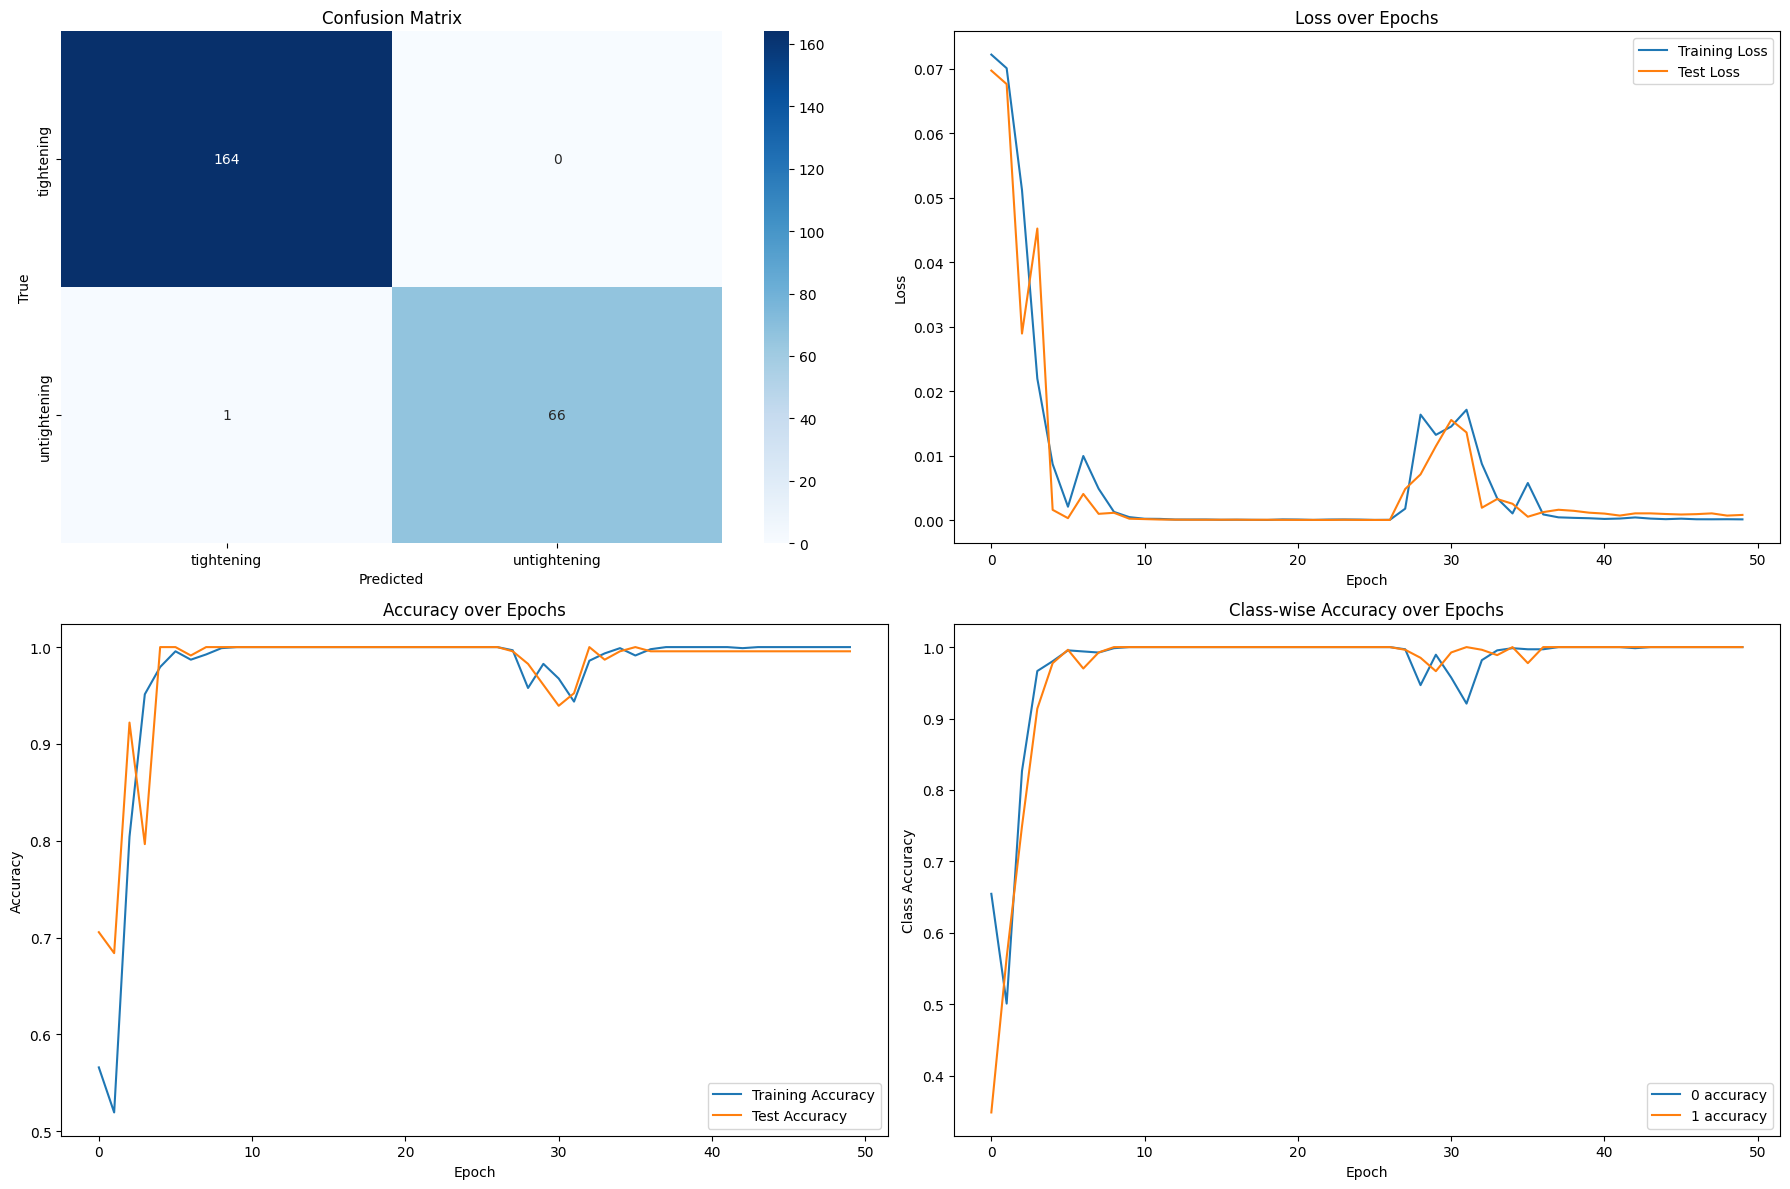

In [13]:

# Enhanced LSTM model with more hidden layers
class EnhancedToolLSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(EnhancedToolLSTM, self).__init__()
        # Three LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(hidden_size2, hidden_size3, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)

        # Expanded fully connected layers
        self.fc1 = nn.Linear(hidden_size3, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.output = nn.Linear(16, num_classes)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out, _ = self.lstm3(out)
        out = self.dropout3(out)
        out = out[:, -1, :]  # Last time step

        out = self.leaky_relu(self.bn1(self.fc1(out)))
        out = self.leaky_relu(self.bn2(self.fc2(out)))
        out = self.leaky_relu(self.bn3(self.fc3(out)))
        out = self.relu(self.fc4(out))
        out = self.relu(self.fc5(out))
        out = self.output(out)
        return out

# Dynamic Focal Loss with adjustable class weights
class DynamicFocalLoss(nn.Module):
    def __init__(self, initial_weights=None, gamma=2.0, adjustment_rate=0.1, max_adjustment=0.5):
        super(DynamicFocalLoss, self).__init__()
        self.initial_weights = initial_weights
        self.weights = initial_weights.clone() if initial_weights is not None else None
        self.gamma = gamma
        self.adjustment_rate = adjustment_rate
        self.max_adjustment = max_adjustment
        self.class_performance = None

    def update_weights(self, class_performance):
        """Adjust weights based on class performance (accuracy per class)"""
        if self.weights is None:
            return
            
        # Calculate adjustment factor (boost weights for poorly performing classes)
        adjustment_factors = 1.0 - class_performance
        adjustment_factors = torch.clamp(adjustment_factors * self.adjustment_rate, 
                                      -self.max_adjustment, self.max_adjustment)
        
        # Apply adjustment
        new_weights = self.weights * (1 + adjustment_factors)
        new_weights = new_weights / new_weights.sum()  # Renormalize
        
        # Store for next epoch
        self.weights = new_weights
        self.class_performance = class_performance

    def forward(self, inputs, targets):
        logpt = nn.functional.log_softmax(inputs, dim=1)
        pt = torch.exp(logpt)
        logpt = logpt.gather(1, targets.view(-1, 1))
        pt = pt.gather(1, targets.view(-1, 1))

        if self.weights is not None:
            weights_t = self.weights.gather(0, targets)
            logpt = logpt * weights_t.view(-1, 1)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        return loss.mean()

#----------------------------------------------- Main Execution ----------------------------------------------------------------#
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedToolLSTM(input_size=X.shape[2], 
                        hidden_size1=128, 
                        hidden_size2=64, 
                        hidden_size3=32, 
                        num_classes=num_of_classes).to(device)

# Initialize class weights (inverse of class frequencies)
initial_weights = 1. / counts_train.float()
initial_weights = initial_weights / initial_weights.sum()
initial_weights = initial_weights.to(device)

# Dynamic loss function
criterion = DynamicFocalLoss(initial_weights=initial_weights, 
                           gamma=2.0, 
                           adjustment_rate=0.1,
                           max_adjustment=0.3)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Initialize containers for tracking metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
class_performance_history = []  # To track per-class accuracy

# Training loop with test evaluation each epoch
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    class_correct = torch.zeros_like(initial_weights)
    class_total = torch.zeros_like(initial_weights)
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Track per-class accuracy
        for l in torch.unique(labels):
            mask = labels == l
            class_correct[l] += (predicted[mask] == labels[mask]).sum().item()
            class_total[l] += mask.sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)
    
    # Calculate per-class accuracy
    class_performance = class_correct / class_total.clamp(min=1)  # Avoid division by zero
    class_performance_history.append(class_performance.cpu().numpy())
    
    # Update class weights based on performance
    criterion.update_weights(class_performance)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_correct / test_total)
    
    # Update learning rate
    scheduler.step(test_losses[-1])

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
    print(f"  Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")
    print(f"  Class Performance: {dict(zip([label_encoder.inverse_transform([i])[0] for i in range(len(class_performance))], [f'{acc:.4f}' for acc in class_performance]))}")
    print(f"  Current Weights: {dict(zip([label_encoder.inverse_transform([i])[0] for i in range(len(criterion.weights))], [f'{w:.4f}' for w in criterion.weights]))}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

# Final evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

TT = cm[0, 0]
TF = cm[0, 1]
FT = cm[1, 0]
FF = cm[1, 1]
print(f"TT (True tightening): {TT}")
print(f"TF (Tightening predicted as untightening): {TF}")
print(f"FT (Untightening predicted as tightening): {FT}")
print(f"FF (True untightening): {FF}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['tightening', 'untightening']))

# Plotting
plt.figure(figsize=(18, 12))

# Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['tightening', 'untightening'],
            yticklabels=['tightening', 'untightening'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Loss
plt.subplot(2, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy
plt.subplot(2, 2, 3)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Class Performance
plt.subplot(2, 2, 4)
class_perf_array = np.array(class_performance_history)
for i in range(class_perf_array.shape[1]):
    plt.plot(class_perf_array[:, i], label=f'{label_encoder.inverse_transform([i])[0]} accuracy')
plt.xlabel('Epoch')
plt.ylabel('Class Accuracy')
plt.title('Class-wise Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()